In [35]:
# #Data prep
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense

import numpy as np

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised = True, with_info = True)

In [36]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


- Number training images: 60.000
- Number test set: 10.000
- Image shape: (28,28,1)
- Range pixel Values: 0 - 255

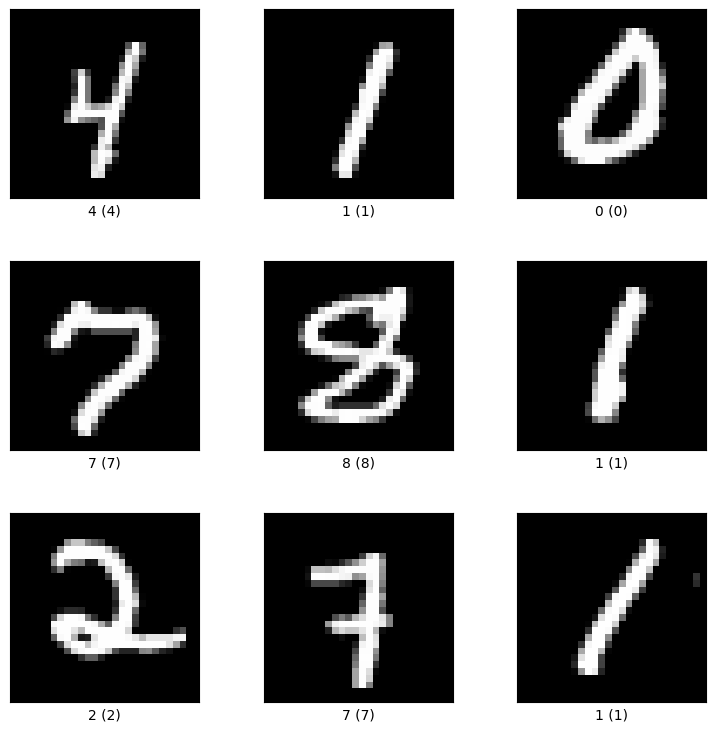

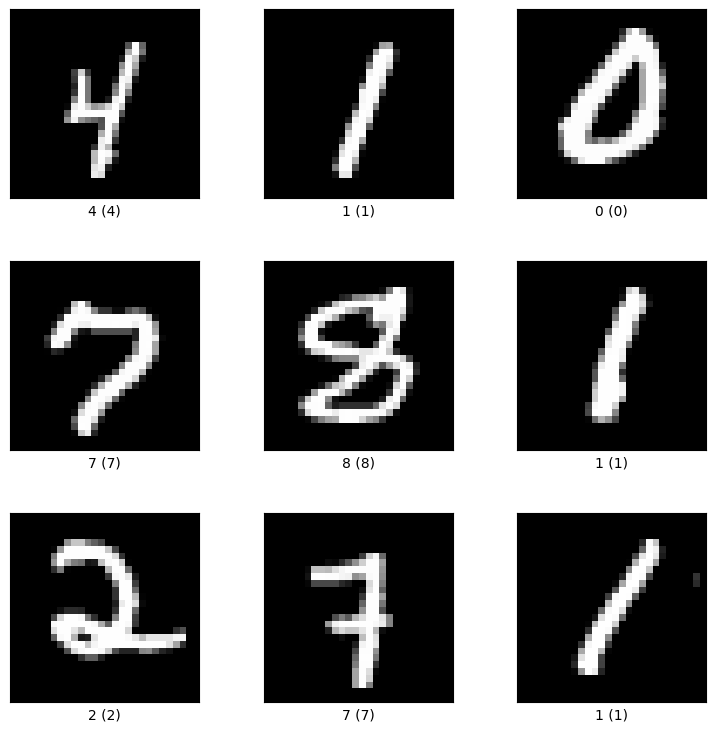

In [37]:
tfds.show_examples(train_ds , ds_info)

In [38]:
def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [39]:

class Dense(tf.keras.layers.Layer):
    def __init__(self, n_units, activation_function, **kwargs):
        super(Dense, self).__init__(**kwargs)
        # no variables created
        self.n_units = n_units
        self.activation_function = activation_function

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.n_units]), name='weights')
        self.b = tf.Variable(tf.zeros([self.n_units]), name='bias')

    def call(self, inputs):
        x = inputs @ self.w + self.b
        return self.activation_function(x)

# instantiate the layer
dense_layer = Dense(n_units=10, activation_function=tf.nn.sigmoid)

In [56]:
# from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        # self.layer1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        # self.layer2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        # self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

        self.layer1 = Dense(50, activation_function=tf.nn.sigmoid)
        self.layer2 = Dense(50, activation_function=tf.nn.sigmoid)

        self.out = Dense(10, activation_function=tf.nn.softmax)


    @tf.function
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)

        x = self.out(x)
        return x


In [41]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [62]:
#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1128125
Epoch: 1 starting with accuracy 0.680625
Epoch: 2 starting with accuracy 0.7634375
Epoch: 3 starting with accuracy 0.801875
Epoch: 4 starting with accuracy 0.8121875
Epoch: 5 starting with accuracy 0.8365625
Epoch: 6 starting with accuracy 0.8540625
Epoch: 7 starting with accuracy 0.8578125
Epoch: 8 starting with accuracy 0.87
Epoch: 9 starting with accuracy 0.8753125


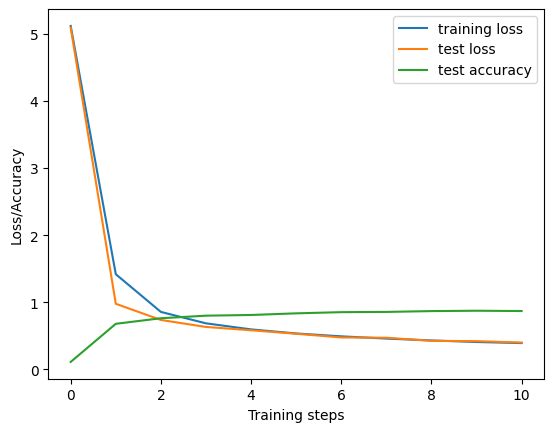

In [63]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training loss","test loss", "test accuracy"))
plt.show()

**3. Adjusting the Hyperparameters of your model**

1. change sigmoid activation function for the hidden layers to sigmoid activation function:
- first iteration using the sigmoid activation function with 10 epochs had accuracy of 4.82 in the end, the second training had an accuracy of 9.24 and the third 6.85
- in the first iteration of the training with relu as activation function, the accuracy was 4.35 in the end. The second iteration however only showed little improvements on the accuracy during the first epochs (from 0.92 to 0.1) and then always changing between 0.91 and 0.11. I guess it the gradient descent ended up in a local minima and although we used the stochastic gradient descent it couldn't really find its way out of this minima. In the third training iteration, it seems that applying the gradient still resulted in getting stuck in a local minima however to the second iteration, the accuracy increased really slowly from 0.1 to 0.18 in 10 epochs.
-> using relu resulted in lower accuracy and also ten to get stuck more in local optimas than using sigmid activation function


2. change number of layers and units
- changing the numbers of layers of the network and their number of units significantly influenced the time of the training iteration. I changed the numbers of layers from two to 10 and their number of units from 256 to 50 each, so that they had roughly the same number of units in total. One training iteration for the one with the multiple layers took way longer than one iteration with only two layers. The accury of the the model with more layers was also lower (0.2) the one with the fewer layers (0.7 in average), however it improved constantly. It surprised me that the networkwith more ayers, but fewer units within the layer took longer to train the the other one, as in my understanding the calculations are faster when using more layers with less units, then the other way around.

3. change learning rate
- changing the learning rate from 0.001 to 0.1 resulted in improving the initial accuracy way faster during the first epochs. This is quite logical, as the model learns faster with a higher learning rate. The accuracy after one training step (0.93) was also higher with the higher learning rate, although the two layers of the model only contained 50 instead of 256 units.

4. change the optimizer
- changing the optimizer from SGD to RMSprop resulted in getting stuck in a local optima more often as compared to using SGD. Leaving the other model parameters exactly the same, using SGD did not result in a local optima all three iterations of a training process. Whereas in all three iterations with RMSprop ended up in a local optimum. The reason could be that the SGD optimize does not always take a step down the gradient, but also with a certain probability adjust the weights such that the accuracy decreases, in order to avoid local minima